In [6]:
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib as mpl

# 全局样式设置
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300

def analyze_label_distribution(df, label_column='Dominant Algae Species', split_char='、|>|；'):
    """Analyze distribution of algal species labels and visualize"""
    print("Starting label distribution analysis...")

    # Process algal labels
    algae_labels = df[label_column].str.split(split_char).apply(lambda x: [i.strip() for i in x])
    algae_labels=algae_labels
    # 1. Basic statistics: Labels per sample distribution
    label_counts_per_sample = algae_labels.apply(len)

    plt.figure(figsize=(8, 7))
    ax = sns.countplot(x=label_counts_per_sample, palette='mako')
    ax.set_title('Number of Labels per Sample Distribution', pad=15, fontsize=18, fontweight='bold')
    ax.set_xlabel('Number of Labels', labelpad=10, fontsize=16)
    ax.set_ylabel('Sample Count', labelpad=10, fontsize=16)
    ax.tick_params(labelsize=16)
    # Add count annotations
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                   (p.get_x() + p.get_width()/2., p.get_height()),
                   ha='center', va='bottom',
                   xytext=(0, 5), textcoords='offset points',
                   fontsize=14)

    plt.tight_layout()
    plt.savefig("label_count_per_sample.png")
    plt.close()

    # 2. Label frequency analysis
    all_labels = []
    for labels in algae_labels:
        all_labels.extend(labels)

    label_counts = pd.Series(all_labels).value_counts()

    # 2.1 Horizontal bar chart
    plt.figure(figsize=(10, max(6, len(label_counts)*0.3)))
    ax = sns.barplot(x=label_counts.values, y=label_counts.index, palette='mako')
    ax.set_title('Algal Species Frequency Distribution', pad=15, fontsize=18, fontweight='bold')
    ax.set_xlabel('Occurrence Count', labelpad=10, fontsize=16)
    ax.set_ylabel('Algal Species', labelpad=10, fontsize=16)
    ax.tick_params(labelsize=14)

    # Add value annotations
    for i, v in enumerate(label_counts.values):
        ax.text(v + 0.5, i, str(v), va='center', fontsize=12)

    plt.tight_layout()
    plt.savefig("label_frequency_horizontal.png")
    plt.close()

    # 2.2 Pie chart
    plt.figure(figsize=(10, 10))
    label_percentages = label_counts / label_counts.sum() * 100

    if len(label_percentages) > 10:
        others_sum = label_percentages[7:].sum()
        top_labels = label_percentages[:7].copy()
        top_labels['Others'] = others_sum
        labels = top_labels.index
        sizes = top_labels.values
    else:
        labels = label_percentages.index
        sizes = label_percentages.values

    explode = [0.1 if i == 0 else 0 for i in range(len(labels))]
    colors = plt.cm.tab10(np.linspace(0, 1, len(labels)))
    wedges, texts, autotexts = plt.pie(sizes, labels=labels,
                                      autopct='%1.1f%%', startangle=90,
                                      shadow=False, explode=explode,
                                      colors=colors,
                                      textprops={'fontsize': 24})

    plt.setp(autotexts, size=24, weight="bold")
    plt.title('Algal Species Distribution (Top 7)', fontsize=24, fontweight='bold', pad=0)
    plt.tight_layout()
    plt.savefig("label_distribution_pie.png")
    plt.close()

    # 3. Multi-label analysis
    mlb = MultiLabelBinarizer()
    encoded_labels = mlb.fit_transform(algae_labels)
    class_names = mlb.classes_

    # 3.1 Class occurrence statistics
    class_counts = encoded_labels.sum(axis=0)
    class_percentages = class_counts / len(encoded_labels) * 100

    print("\nAlgal Species Occurrence Statistics:")
    for i, name in enumerate(class_names):
        print(f"{name}: {class_counts[i]} instances ({class_percentages[i]:.1f}%)")

    # 3.2 Co-occurrence heatmap - MODIFIED TO SHOW ONLY TOP 7
    # Get indices of top 7 classes by frequency
    top7_indices = np.argsort(-class_counts)[:7]
    top7_class_names = [class_names[i] for i in top7_indices]

    # Create co-occurrence matrix for top 7 classes
    co_occurrence_top7 = np.zeros((7, 7))

    for sample in encoded_labels:
        for i, idx_i in enumerate(top7_indices):
            for j, idx_j in enumerate(top7_indices):
                if sample[idx_i] == 1 and sample[idx_j] == 1:
                    co_occurrence_top7[i, j] += 1

    # Create a mask for the upper triangle and diagonal
    mask = np.zeros_like(co_occurrence_top7, dtype=bool)
    mask[np.triu_indices_from(mask, k=0)] = True  # Include diagonal (k=0)

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(co_occurrence_top7.astype(int),
                    annot=True, fmt='d',
                    cmap='YlGnBu', linewidths=0.8,
                    xticklabels=top7_class_names,
                    yticklabels=top7_class_names,
                    square=True,
                    mask=mask,  # Apply mask to hide upper triangle and diagonal
                    cbar_kws={"shrink": 0.8, "label": "Co-occurrence Count"},
                    annot_kws={"size": 22})  # Adjust size of annotated numbers

    plt.title('Top 7 Algal Species Co-occurrence Matrix', pad=20, fontsize=24, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=22)
    plt.yticks(rotation=0, fontsize=22)  # Set y-ticks to horizontal orientation
    plt.tight_layout()
    plt.savefig("label_co_occurrence.png")
    plt.close()
    # Create co-occurrence matrix for all classes
    co_occurrence_all = np.zeros((len(class_names), len(class_names)))

    for sample in encoded_labels:
        for i in range(len(class_names)):
            for j in range(len(class_names)):
                if sample[i] == 1 and sample[j] == 1:
                    co_occurrence_all[i, j] += 1

    # Create a mask for the upper triangle and diagonal
    mask_all = np.zeros_like(co_occurrence_all, dtype=bool)
    mask_all[np.triu_indices_from(mask_all, k=0)] = True  # Include diagonal (k=0)

    plt.figure(figsize=(16, 14))  # Even larger figure to accommodate annotations
    ax = sns.heatmap(co_occurrence_all.astype(int),
                    annot=True,  # Display the numeric values
                    fmt='d',     # Use integer format
                    cmap='YlGnBu',
                    linewidths=0.5,
                    xticklabels=class_names,
                    yticklabels=class_names,
                    square=True,
                    mask=mask_all,  # Apply mask to hide upper triangle and diagonal
                    cbar_kws={"shrink": 0.8, "label": "Co-occurrence Count"},
                    annot_kws={"size": 15})  # Small font size for the numbers

    plt.title('Complete Algal Species Co-occurrence Matrix', pad=20, fontsize=24, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=15)  # Adjust font size and rotation as needed
    plt.yticks(rotation=0, fontsize=15)  # Smaller font to fit all class names
    plt.tight_layout()
    plt.savefig("all_label_co_occurrence.png", dpi=300)  # Higher DPI for better quality
    plt.close()

    # 4. Cumulative distribution
    sorted_counts = label_counts.sort_values(ascending=False)
    cumulative_percentage = np.cumsum(sorted_counts) / np.sum(sorted_counts) * 100

    plt.figure(figsize=(10, 7))
    plt.plot(range(1, len(sorted_counts)+1), cumulative_percentage,
            marker='o', markersize=6, linewidth=2, color='#2c7bb6')
    plt.axhline(y=80, color='#d7191c', linestyle='--', linewidth=2, alpha=0.7)

    n_classes_80pct = np.argmax(cumulative_percentage >= 80) + 1
    plt.axvline(x=n_classes_80pct, color='#2c7bb6', linestyle='--', linewidth=2, alpha=0.7)

    # Add annotation for the intersection point
    plt.scatter([n_classes_80pct], [80], s=100, color='red', zorder=5)
    plt.annotate(f'Top {n_classes_80pct} species (80%)',
                xy=(n_classes_80pct, 80),
                xytext=(n_classes_80pct+2, 82),
                fontsize=14,
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

    plt.title('Cumulative Distribution of Algal Species', pad=15, fontsize=18, fontweight='bold')
    plt.xlabel('Number of Species (Sorted by Frequency)', labelpad=10, fontsize=16)
    plt.ylabel('Cumulative Percentage (%)', labelpad=10, fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.tick_params(labelsize=14)

    # Add background color
    plt.gca().set_facecolor('#f8f9fa')

    plt.tight_layout()
    plt.savefig("label_cumulative_distribution.png")
    plt.close()

    return algae_labels, class_names, encoded_labels, label_counts

def main():
    """Main function"""
    print("Loading data...")
    df = pd.read_excel(R"datasets.xlsx")

    print(f"Cleaned data shape: {df.shape}")

    # Analyze label distribution
    labels_info = analyze_label_distribution(df)

    # Additional statistics
    _, class_names, encoded_labels, _ = labels_info

    print(f"\nTotal samples: {len(encoded_labels)}")
    print(f"Unique label categories: {len(class_names)}")

    multi_label_counts = encoded_labels.sum(axis=1)
    avg_labels_per_sample = multi_label_counts.mean()
    max_labels = multi_label_counts.max()

    print(f"Average labels per sample: {avg_labels_per_sample:.2f}")
    print(f"Maximum labels in a single sample: {max_labels}")

    imbalance_ratio = encoded_labels.sum(axis=0).max() / encoded_labels.sum(axis=0).min()
    print(f"Class imbalance ratio (most/least frequent): {imbalance_ratio:.2f}")


if __name__ == "__main__":
    main()

Loading data...
Cleaned data shape: (114, 14)
Starting label distribution analysis...

Algal Species Occurrence Statistics:
Achnanthes: 1 instances (0.9%)
Anabaena: 13 instances (11.4%)
Ankistrodesmus: 4 instances (3.5%)
Aphanizomenon: 2 instances (1.8%)
Ceratium: 3 instances (2.6%)
Chlamydomonas: 6 instances (5.3%)
Chroomonas: 19 instances (16.7%)
Coelastrum: 4 instances (3.5%)
Crucigenia Morren: 1 instances (0.9%)
Cryptomonas: 45 instances (39.5%)
Cyclotella: 24 instances (21.1%)
Dinobryon: 1 instances (0.9%)
Dolichospermum: 1 instances (0.9%)
Limnothrix: 27 instances (23.7%)
Melosira: 9 instances (7.9%)
Naked algae: 1 instances (0.9%)
Navicula: 2 instances (1.8%)
Pandorina: 1 instances (0.9%)
Peridiniopsis: 3 instances (2.6%)
Peridinium: 4 instances (3.5%)
Pseudanabaena: 48 instances (42.1%)
Raphidiopsis: 1 instances (0.9%)
Synedra: 2 instances (1.8%)
Synurales: 2 instances (1.8%)
chlorella: 1 instances (0.9%)

Total samples: 114
Unique label categories: 25
Average labels per sample

C:\Users\52551\AppData\Local\Temp\ipykernel_17336\2977794262.py:57: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=True, color='white',


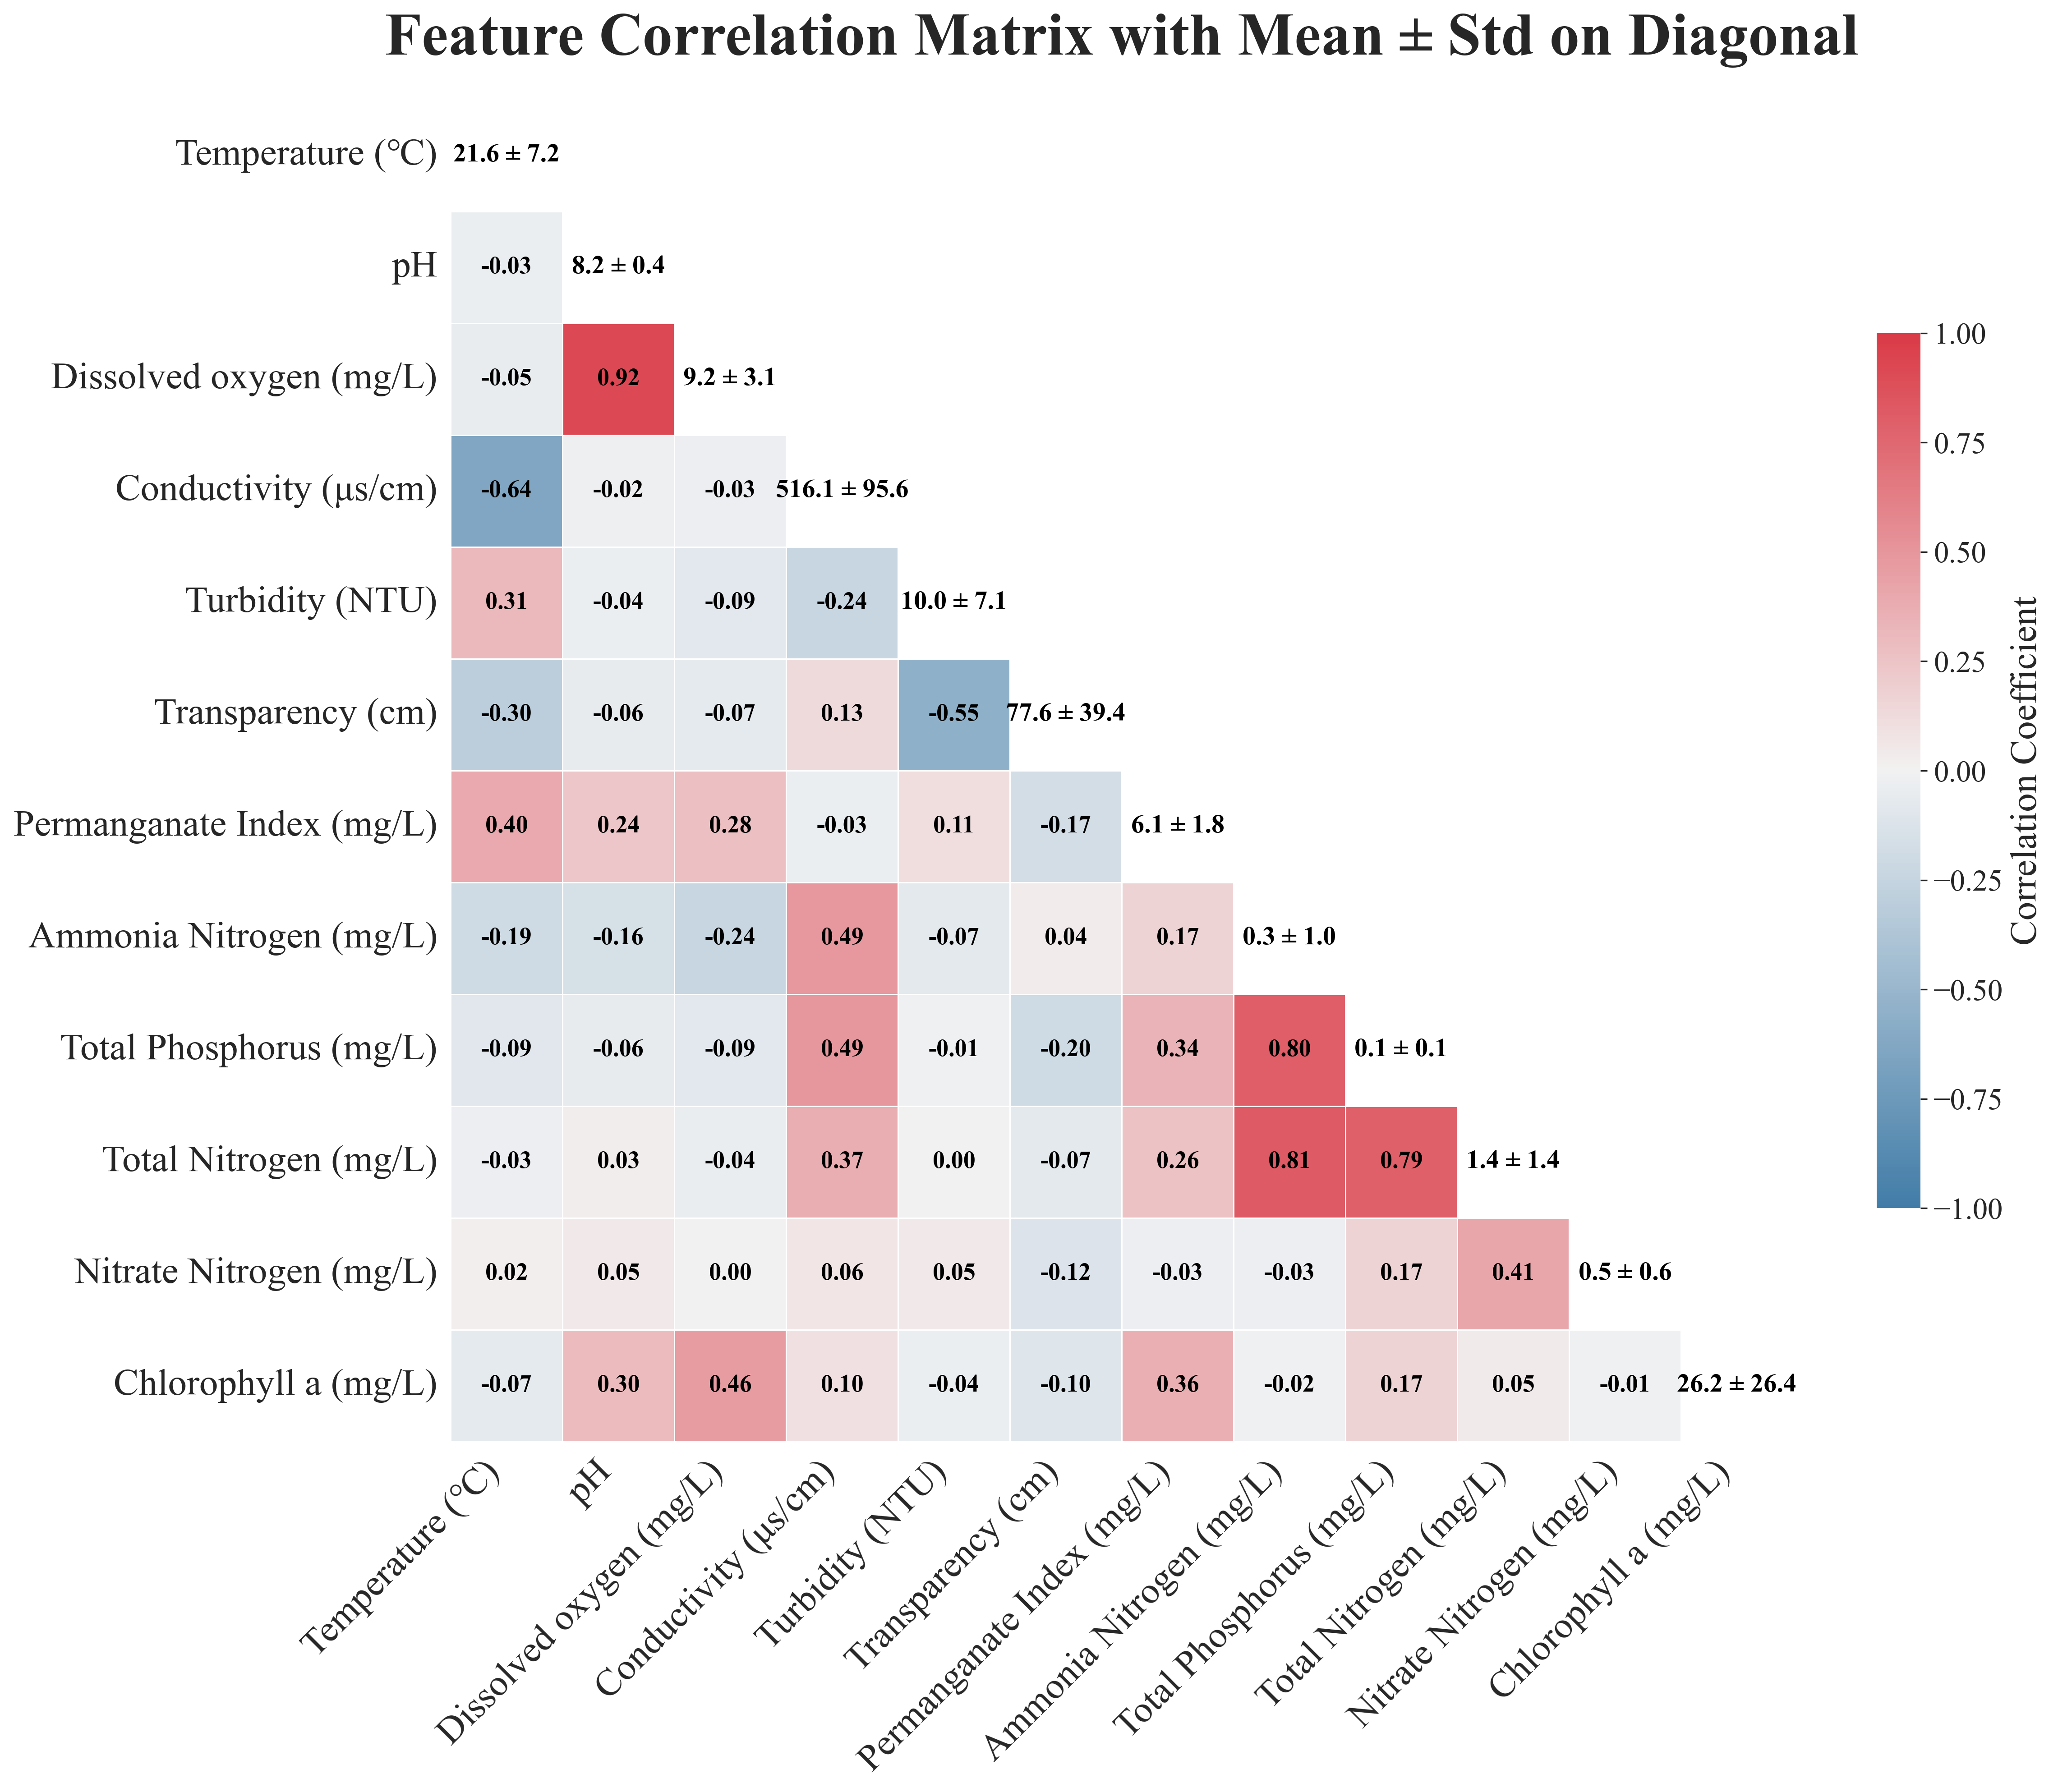

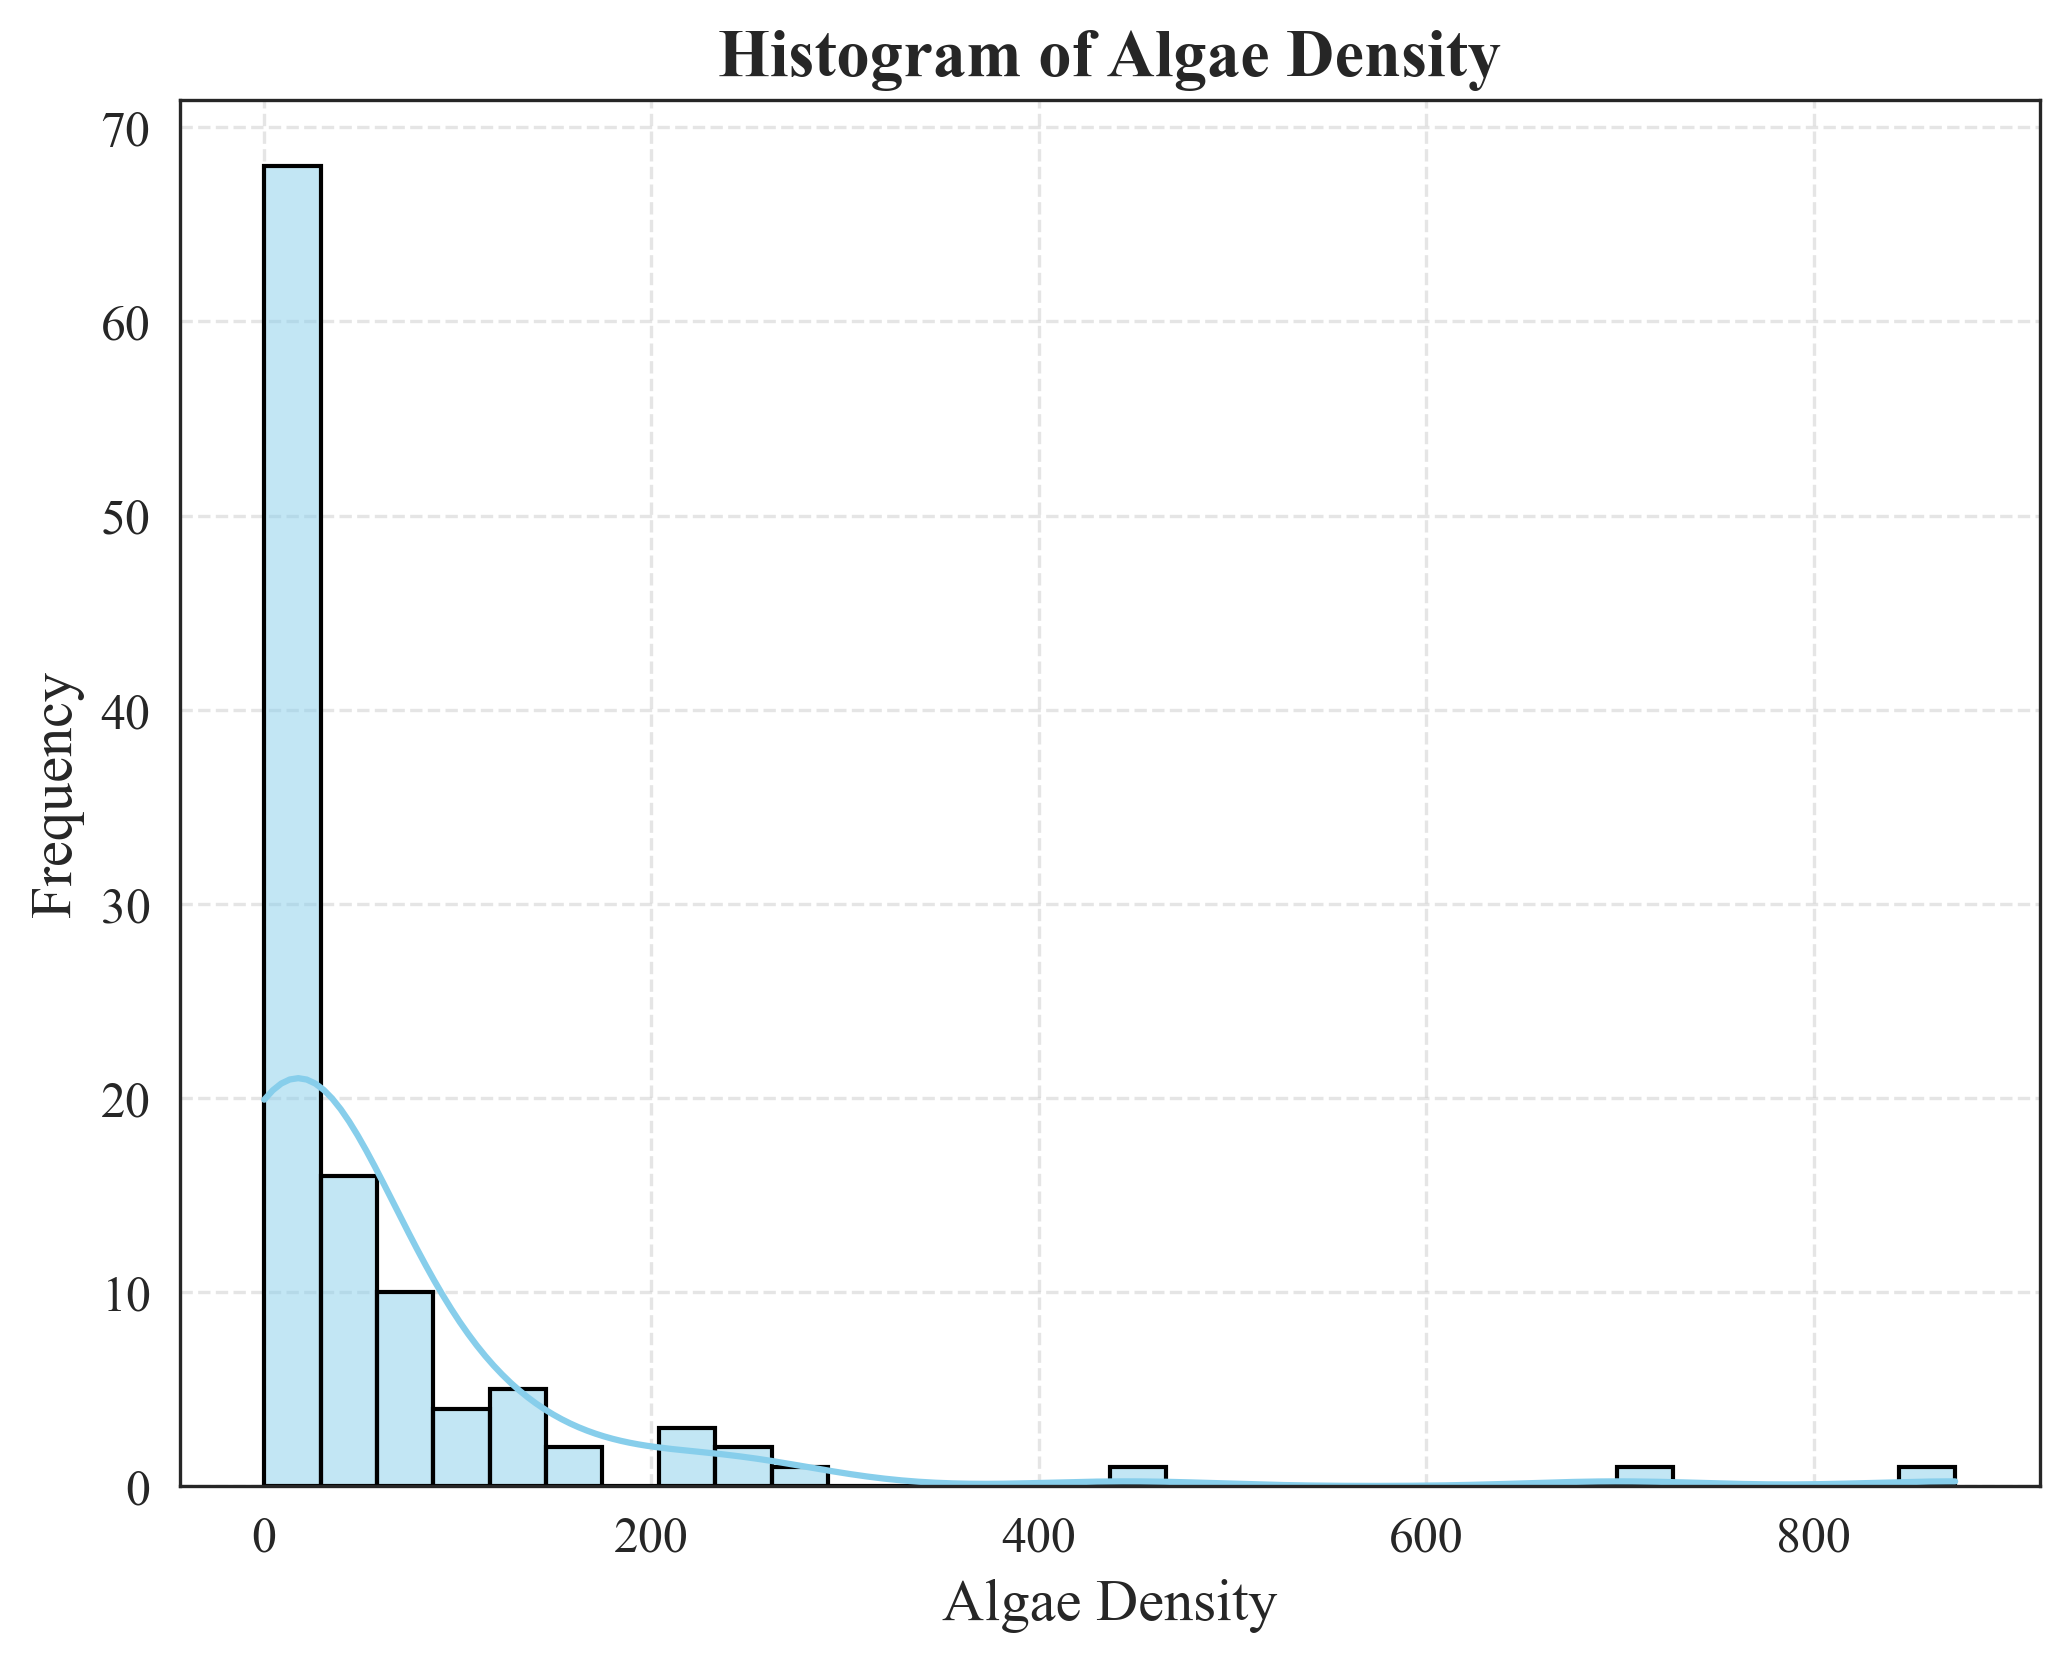

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# 设置全局字体为 Times New Roman
sns.set_style("white")
mpl.rcParams['font.family'] = 'Times New Roman'

def plot_final_corr_heatmap(df, save_path=None):
    """
    美化热图：遮盖对角线色块，仅保留文字，左下角显示相关系数
    """
    feature_names = df.columns
    n = len(feature_names)

    fig, ax = plt.subplots(figsize=(16, 14))
    corr = df.corr()

    # 遮掉对角线以上
    mask = np.triu(np.ones_like(corr, dtype=bool), k=0)  # 对角线及以上被遮住（即不会画颜色）

    # 深色调
    cmap = sns.diverging_palette(240, 10, as_cmap=True)

    # 热图绘制（不画对角线）
    cbar = sns.heatmap(corr, mask=mask, annot=False, fmt=".2f", cmap=cmap, center=0,
                vmin=-1, vmax=1, square=True, linewidths=0.7,
                cbar_kws={"shrink": 0.6, "label": "Correlation Coefficient"},
                ax=ax, xticklabels=True, yticklabels=True)

    # 增大颜色条的标签字体大小
    cbar.figure.axes[-1].yaxis.label.set_size(20)  # 增大颜色条标签字体
    cbar.figure.axes[-1].tick_params(labelsize=16)  # 增大颜色条刻度字体

    # 坐标轴 tick 字体
    ax.set_xticklabels(feature_names, rotation=45, ha='right', fontsize=20)
    ax.set_yticklabels(feature_names, rotation=0, fontsize=20)

    # 左下角相关系数加粗显示
    for i in range(n):
        for j in range(i):
            val = corr.iloc[i, j]
            ax.text(j + 0.5, i + 0.5, f"{val:.2f}",
                    ha='center', va='center',
                    fontsize=13, fontweight='bold', color='black')

    # 对角线加白色补丁 + 文字
    for i in range(n):
        col = df.iloc[:, i]
        mean = col.mean()
        std = col.std()
        txt = f"{mean:.1f} ± {std:.1f}"

        # 加白色方框（遮盖热图默认颜色）
        ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=True, color='white',
                                   edgecolor='gray', linewidth=0.5, zorder=2))

        # 放文字
        ax.text(i + 0.5, i + 0.5, txt,
                ha='center', va='center',
                fontsize=14, fontweight='bold', color='black', zorder=3)

    # 标题
    ax.set_title("Feature Correlation Matrix with Mean ± Std on Diagonal",
                 fontsize=32, fontweight='bold', pad=24)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_algae_density_histogram(series, save_path=None):
    """
    绘制倒数第二列藻类密度的直方图
    """
    plt.figure(figsize=(8, 6))
    sns.histplot(series, bins=30, kde=True, color='skyblue', edgecolor='black')
    plt.title('Histogram of Algae Density', fontsize=16,fontweight='bold')
    plt.xlabel('Algae Density', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def main():
    # 读取数据
    df = pd.read_excel('datasets.xlsx')

    # 取前12个特征
    features = df.iloc[:, :12]
    plot_final_corr_heatmap(features, save_path="final_corr_heatmap.png")

    # 2. 倒数第二列：藻类密度直方图
    algae_density = df.iloc[:, -2]
    plot_algae_density_histogram(algae_density, save_path='algae_density_hist.png')

if __name__ == "__main__":
    main()